In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Ładowanie danych

Loading MNIST database...
MNIST dataset loaded.


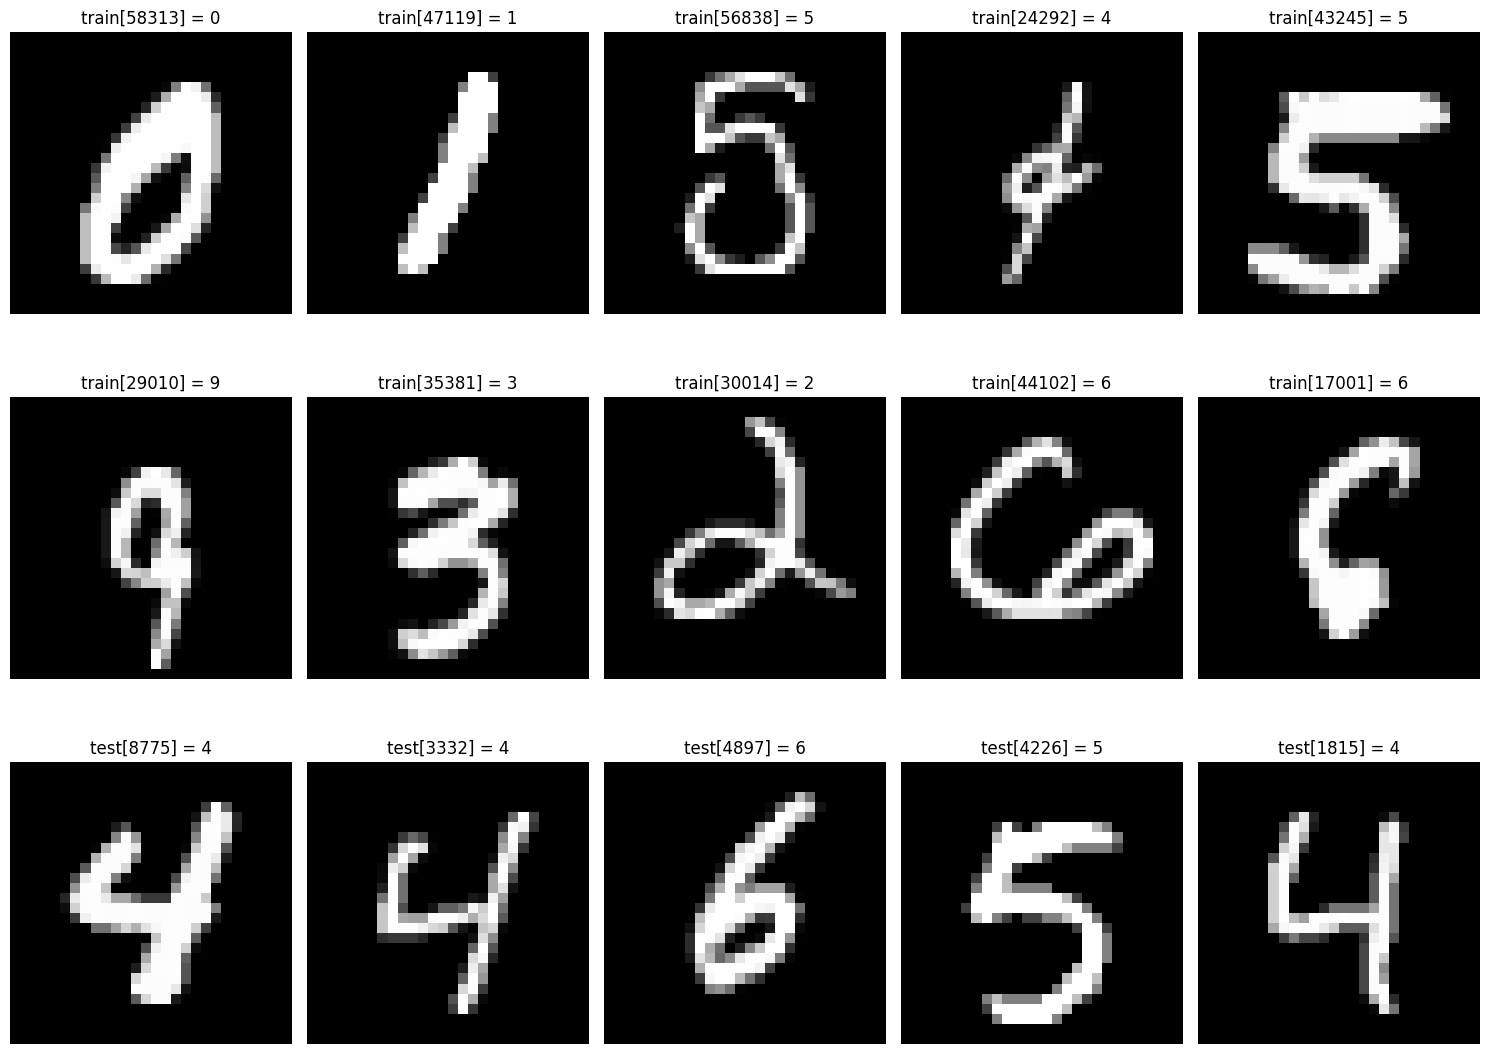

In [2]:
import struct
from array import array
import random

np.random.seed(42)

class MnistDataloader(object):
    def __init__(self, train_img_path, train_label_path, test_img_path, test_label_path):
        self.train_img_path = train_img_path
        self.train_label_path = train_label_path
        self.test_img_path = test_img_path
        self.test_label_path = test_label_path

    def read_img_labels(self, img_path, label_path):
        # Loading labels
        with open(label_path, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch (labels), expected 2049, got {magic}')
            labels = array("B", file.read())

        # Loading images
        with open(img_path, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch (images), expected 2051, got {magic}')
            image_data = array("B", file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_img_labels(self.train_img_path, self.train_label_path)
        x_test, y_test = self.read_img_labels(self.test_img_path, self.test_label_path)
        return (x_train, y_train), (x_test, y_test)

# File paths
train_img_path = './data/train-images.idx3-ubyte'
train_label_path = './data/train-labels.idx1-ubyte'
test_img_path = './data/t10k-images.idx3-ubyte'
test_label_path = './data/t10k-labels.idx1-ubyte'

# Loading data
print('Loading MNIST database...')
dataloader = MnistDataloader(train_img_path, train_label_path, test_img_path, test_label_path)
(x_train, y_train), (x_test, y_test) = dataloader.load_data()
print('MNIST dataset loaded.')

# Showing images
def show_images(images, title_text):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(15, 15))
    for idx, (image, title) in enumerate(zip(images, title_text), start=1):
        plt.subplot(rows, cols, idx)
        plt.imshow(image, cmap=plt.cm.gray)
        if title:
            plt.title(title, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Randomizing images to show
random_images = []
for _ in range(10):
    r = random.randint(0, len(x_train) - 1)
    random_images.append((x_train[r], f'train[{r}] = {y_train[r]}'))
for _ in range(5):
    r = random.randint(0, len(x_test) - 1)
    random_images.append((x_test[r], f'test[{r}] = {y_test[r]}'))

show_images([x[0] for x in random_images], [x[1] for x in random_images])


In [3]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLu(Z):
    return np.maximum(0, Z)

def deriv_ReLu(Z):
    return Z > 0

def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shifted)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

#def one_hot(Y):
#    one_hot_Y = [[1 if y_val==num else 0 for y_val in Y] for num in range(10)]
#    return np.array(one_hot_Y)

def one_hot(Y):
    one_hot_Y = np.zeros((10, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y


def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = Y.size
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLu(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [4]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradiant_descend(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        # if i % 100 == 0:
           # print("Iteration: ", i)
           # print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

In [5]:
X_tr = np.array(x_train).reshape(len(x_train), 784).T
X_tr = X_tr / 255.0
Y_tr = np.array(y_train)

X_te = np.array(x_test).reshape(len(x_test), 784).T
X_te = X_te / 255.0
Y_te = np.array(y_test)

In [6]:
W1, b1, W2, b2 = gradiant_descend(X_tr, Y_tr, Y_tr.size, 0.1)

In [39]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

predictions = get_accuracy(make_predictions(X_te, W1, b1, W2, b2), Y_te)

In [8]:
print(predictions)

0.9376


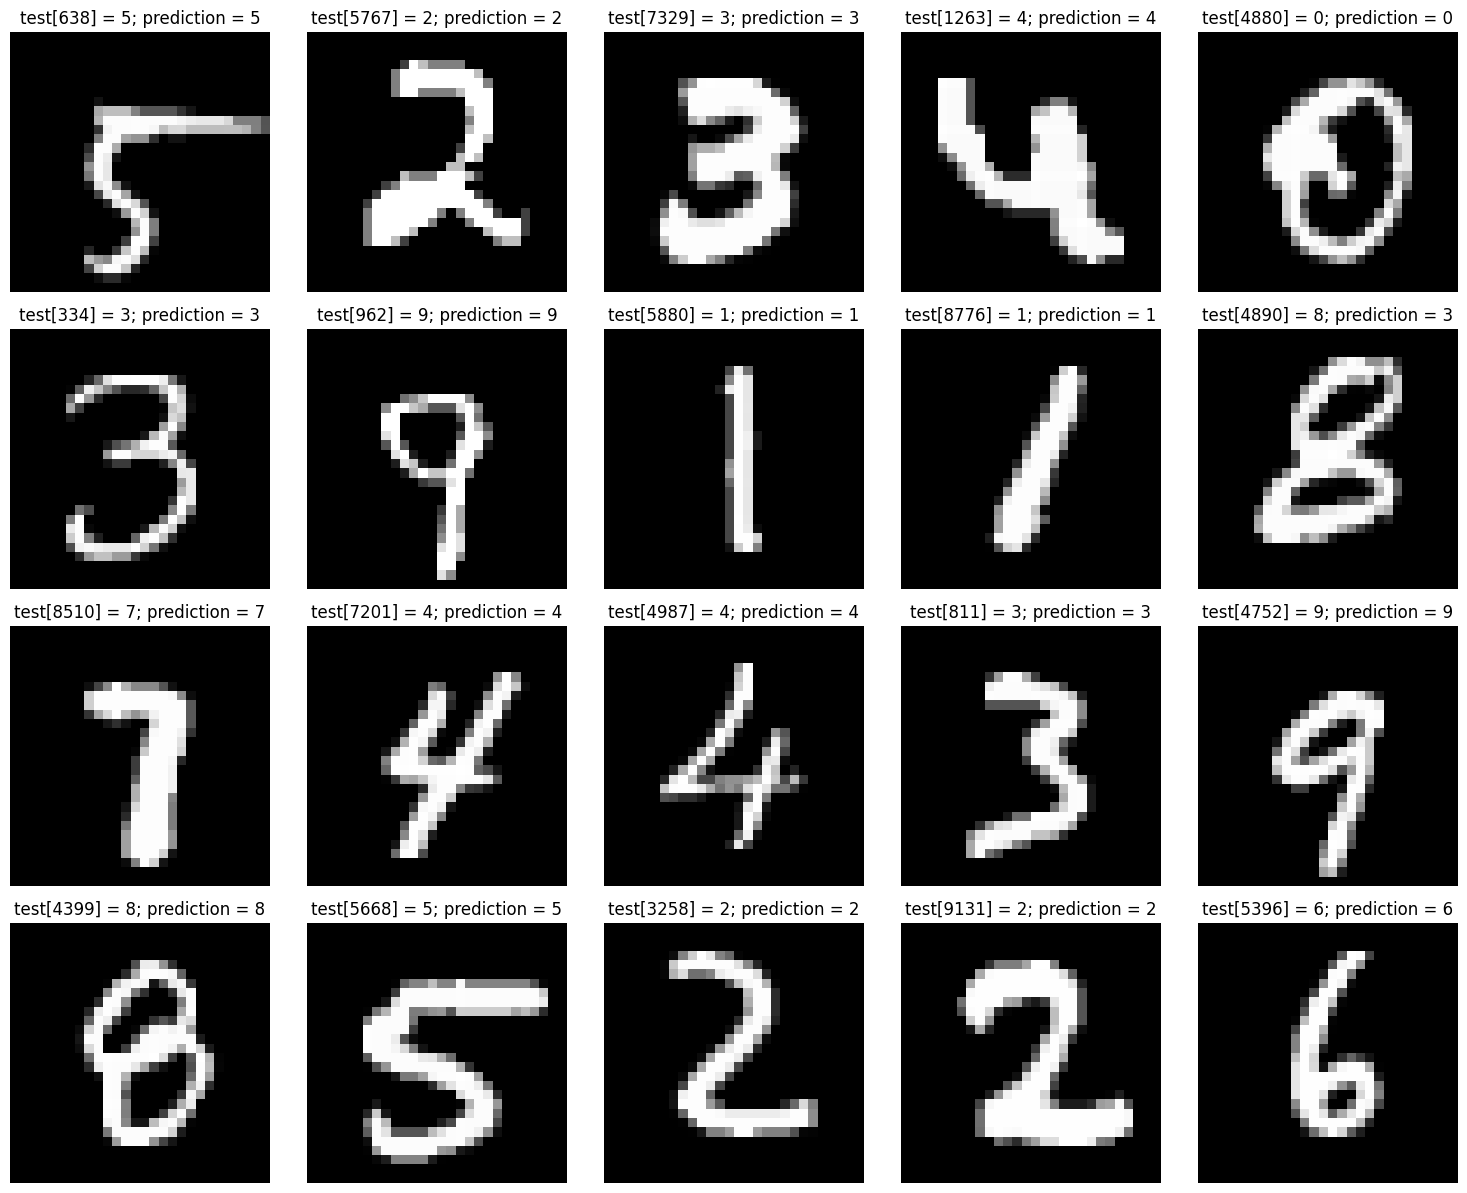

In [40]:
test_images = []
labels = []
for i in range(20):
    r = random.randint(0, len(X_te[0])-1)
    random_test = X_te[:, r]
    test_images.append(random_test.reshape(28, 28))

    prediction = make_predictions(random_test.reshape(-1, 1), W1, b1, W2, b2)[0]
    labels.append(f"test[{r}] = {y_test[r]}; prediction = {prediction}")

show_images(test_images, labels)
